In [1]:
import geopandas as gpd
import pandas as pd
import ee
from src.data import mtbs
from src.data import raster
from src.data import gedi_pipeline
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(raster)


<module 'src.data.raster' from '/home/jk871/fire-regen/src/data/raster.py'>

In [5]:
gedi_burned, gedi_unburned = gedi_pipeline.stage_5_filter_for_regrowth_l4a_sierras(2)

2023-06-14 16:06:17,888 DEBUG: Read in intermediate data from stage 3. [in stage_4_filter_burns_l4a_sierras at /home/jk871/fire-regen/src/data/gedi_pipeline.py:337]
2023-06-14 16:07:01,455 DEBUG: Filter burn areas. [in stage_4_filter_burns_l4a_sierras at /home/jk871/fire-regen/src/data/gedi_pipeline.py:341]
2023-06-14 16:07:03,914 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:378]
2023-06-14 16:07:04,474 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:383]
2023-06-14 16:07:07,950 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:390]
2023-06-14 16:07:08,422 DEBUG: Number of shots that burned exactly once:                 

In [4]:
# Stage 4
gedi_unburned.shape[0]

7852535

### Debug 3x3 sampling

In [4]:
gedi_shots = pd.read_csv('/maps/fire-regen/data/seki_gedi_shots.csv', index_col=0)

In [39]:
br = raster.Raster(raster.BURN_DATA_RASTER, {'burn_severity': 0, 'burn_year': 1, 'burn_counts': 2})
burn_raster_old = raster.RasterSamplerOld(br)
burn_raster = raster.RasterSampler(raster.BURN_DATA_RASTER, raster.BURN_RASTER_BANDS)

In [45]:
gedi_new = burn_raster.sample_3x3(gedi_shots.head(100000), 'lon_lowestmode', 'lat_lowestmode')

In [37]:
gedi_new[gedi_new.burn_severity_mean != 0]

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,l2_quality_flag,l4_quality_flag,...,burn_severity_std,burn_severity_median,burn_year_3x3,burn_year_mean,burn_year_std,burn_year_median,burn_counts_3x3,burn_counts_mean,burn_counts_std,burn_counts_median
212,160640200200123715,2021-10-13 17:36:42.120275+01:00,-118.687460,36.963131,298.735718,139.176147,518.502502,11.116259,1,1,...,0.496904,1.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[0, 1, 0, 1, 0, 1, 0, 0, 1]",0.444444,0.496904,0.0
213,160640200200123716,2021-10-13 17:36:42.128541+01:00,-118.686965,36.963475,49.676140,2.438049,157.122086,11.116365,1,1,...,0.314270,1.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1]",0.111111,0.314270,0.0
215,160640200200123718,2021-10-13 17:36:42.145073+01:00,-118.686018,36.964147,149.608994,45.427628,314.102905,11.135696,1,1,...,0.000000,1.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.0
216,160640200200123719,2021-10-13 17:36:42.153339+01:00,-118.685541,36.964484,199.696198,74.748558,384.828857,11.112156,1,1,...,1.662959,1.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.0
217,160640200200123720,2021-10-13 17:36:42.161605+01:00,-118.685035,36.964833,148.261917,44.754005,311.971893,11.115299,1,1,...,1.247219,1.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[0, 0, 0, 0, 0, 0, 0, 1, 1]",0.222222,0.415740,0.0
222,160640200200123725,2021-10-13 17:36:42.202935+01:00,-118.682590,36.966543,124.036362,31.971586,276.223816,11.100627,1,1,...,2.042753,0.0,"[2001, 0, 0, 2001, 0, 0, 2001, 0, 0]",667.0,943.280446,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.0
295,151340500200080648,2021-08-14 17:19:33.143029+01:00,-118.688420,36.967919,195.174011,72.036858,378.438049,11.101422,1,1,...,1.257079,1.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.0
296,151340500200080649,2021-08-14 17:19:33.151293+01:00,-118.687925,36.968255,135.926712,38.128334,293.872375,11.105191,1,1,...,0.666667,2.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[0, 0, 0, 1, 1, 0, 1, 1, 1]",0.555556,0.496904,1.0
297,151340500200080650,2021-08-14 17:19:33.159557+01:00,-118.687433,36.968592,141.092865,40.901794,301.406128,11.100552,1,1,...,1.227262,2.0,"[2001, 2001, 2001, 2001, 2001, 2001, 2001, 200...",2001.0,0.000000,2001.0,"[1, 1, 1, 1, 0, 0, 1, 0, 0]",0.555556,0.496904,1.0


In [46]:
gedi_old = burn_raster_old.sample_3x3(gedi_shots.head(100000), 'lon_lowestmode', 'lat_lowestmode', 3, [(0,'burn_severity'), (1, 'burn_year'), (2, 'burn_counts')])

In [54]:
gedi_old.burn_counts_median.compare(gedi_new.burn_counts_median)

,self,other


In [7]:
gedi_shots.columns

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'l2_quality_flag',
       'l4_quality_flag', 'degrade_flag', 'beam_type', 'sensitivity',
       'pft_class', 'geometry'],
      dtype='object')

In [2]:
burn_raster = raster.RasterSampler(raster.BURN_DATA_RASTER, raster.BURN_RASTER_BANDS)
lc_raster = raster.RasterSampler(raster.LAND_COVER_RASTER, raster.LAND_COVER_BANDS)
terrain_raster = raster.RasterSampler(raster.TERRAIN_RASTER, raster.TERRAIN_BANDS)

### Match SEKI data

In [4]:
gedi_shots = pd.read_csv('/maps/fire-regen/data/seki_gedi_shots.csv', index_col=0)

In [5]:
gedi_shots = gedi_pipeline.initial_l4a_shot_processing(gedi_shots)

In [6]:
gedi_matched = burn_raster.sample_2x2(gedi_shots, 'longitude', 'latitude')

In [7]:
gedi_matched = lc_raster.sample_2x2(gedi_matched, 'longitude', 'latitude')

In [8]:
gedi_matched = terrain_raster.sample(gedi_matched, 'longitude', 'latitude')

In [16]:
gedi_matched.to_csv(f'/maps/fire-regen/data/seki_matched_all.csv')

### Match L2B data

In [4]:
gedi_shots = pd.read_csv('/maps/fire-regen/data/sierras_gedi_l2b_shots.csv', index_col=0)

In [5]:
gedi_matched = burn_raster.sample_2x2(gedi_shots, 'lon_lowestmode', 'lat_lowestmode')

In [6]:
gedi_matched = lc_raster.sample_2x2(gedi_matched, 'lon_lowestmode', 'lat_lowestmode')

In [ ]:
gedi_matched.to_csv(f'/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')

In [4]:
gedi_shots = pd.read_csv('/maps/fire-regen/data/sierras_gedi_shots.csv', index_col=0)

In [35]:
gedi_matched = burn_raster.sample_2x2(gedi_shots, 'lon_lowestmode', 'lat_lowestmode')

In [39]:
gedi_matched.to_csv(f'/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')

In [38]:
gedi_matched = lc_raster.sample_2x2(gedi_matched, 'lon_lowestmode', 'lat_lowestmode')

In [33]:
gedi_matched

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,l2_quality_flag,l4_quality_flag,...,burn_severity_std,burn_severity_median,burn_year_3x3,burn_year_mean,burn_year_std,burn_year_median,burn_counts_3x3,burn_counts_mean,burn_counts_std,burn_counts_median
0,184890800200086632,2022-03-19 02:41:53.252278+00:00,-117.983310,37.034945,19.594500,2.419877,53.254089,2.981980,1,1,...,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0
1,184891100200081451,2022-03-19 02:41:53.339050+00:00,-117.985725,37.040705,17.788033,1.812951,50.249866,2.982302,1,1,...,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0
2,184891100200081452,2022-03-19 02:41:53.347314+00:00,-117.985239,37.041043,16.219337,1.336309,47.591499,2.982735,1,1,...,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0
3,184891100200081453,2022-03-19 02:41:53.355578+00:00,-117.984755,37.041380,6.750648,-9999.000000,29.955231,2.990220,1,1,...,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0
4,184891100200081454,2022-03-19 02:41:53.363842+00:00,-117.984267,37.041720,4.370386,-9999.000000,24.677294,2.994677,1,1,...,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27629560,145740600300499241,2021-07-09 14:28:27.680490+01:00,-120.454065,40.766560,4.699281,-9999.000000,25.447033,2.993938,1,1,...,0.000000,2.0,"[1990, 1990, 1990, 1990]",1990.0,0.0,1990.0,"[1, 1, 1, 1]",1.00,0.000000,1.0
27629561,145740600300499242,2021-07-09 14:28:27.688756+01:00,-120.453532,40.766257,2.924632,-9999.000000,21.060156,2.998635,1,1,...,0.433013,2.0,"[1990, 1990, 1990, 1990]",1990.0,0.0,1990.0,"[0, 1, 1, 1]",0.75,0.433013,1.0
27629562,145740600300499244,2021-07-09 14:28:27.705288+01:00,-120.452463,40.765649,1.500722,-9999.000000,16.865877,3.004451,1,1,...,0.433013,2.0,"[1990, 1990, 1990, 1990]",1990.0,0.0,1990.0,"[1, 1, 1, 0]",0.75,0.433013,1.0
27629564,145740800300301239,2021-07-09 14:28:27.978045+01:00,-120.463172,40.762280,3.823108,-9999.000000,23.357908,2.996024,1,1,...,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0


In [9]:
gedi_matched_old = pd.read_csv(f'/maps/fire-regen/data/sierras_matched_lc_all.csv', index_col=0)

In [29]:
gedi_matched_old[gedi_matched_old.burn_severity_std!=0].shape[0]

1421293

In [30]:
gedi_matched[gedi_matched.burn_severity_std!=0].shape[0]

949576

In [32]:
gedi_matched_old.shape[0]

9884257

In [13]:
gedi_old = gedi_matched_old[gedi_matched_old.shot_number.isin(gedi_matched.shot_number)]

In [22]:
gedi_old[gedi_old.shot_number == 141320500300286362][['burn_severity_3x3', 'burn_year_3x3', 'burn_counts_3x3', 'burn_sev']]

,burn_severity_3x3,burn_year_3x3,burn_counts_3x3
8439,[2 2 1 2 2 1 2 0 0],[2017 2017 2017 2017 2017 2017 2017 0 0],[1 1 0 1 1 0 1 0 0]


In [24]:
gedi_old[gedi_old.burn_severity_std != 0][['shot_number', 'burn_severity_3x3', 'burn_year_3x3', 'burn_counts_3x3']]

,shot_number,burn_severity_3x3,burn_year_3x3,burn_counts_3x3
8439,141320500300286362,[2 2 1 2 2 1 2 0 0],[2017 2017 2017 2017 2017 2017 2017 0 0],[1 1 0 1 1 0 1 0 0]
8440,141320500300286363,[1 0 0 0 0 0 0 0 0],[2017 0 0 0 0 0 0 0 0],[0 0 0 0 0 0 0 0 0]
8444,141320600300524419,[1 0 0 2 0 0 2 1 0],[2017 0 0 2017 0 0 2017 2017 0],[0 0 0 1 0 0 1 0 0]
8455,28901100300221100,[2 0 0 2 1 0 2 2 0],[2017 0 0 2017 2017 0 2017 2017 0],[1 0 0 1 0 0 1 1 0]
8484,94310800200083134,[2 2 2 1 0 2 0 0 0],[2017 2017 2017 2017 0 2017 0 0 0],[1 1 1 0 0 1 0 0 0]
8514,141320500300286314,[2 0 0 2 0 0 0 0 0],[1996 0 0 1996 0 0 0 0 0],[1 0 0 1 0 0 0 0 0]
8543,169790600200452949,[2 0 0 2 0 0 2 0 0],[1996 0 0 1996 0 0 1996 0 0],[1 0 0 1 0 0 1 0 0]
8544,169790600200452951,[2 2 2 2 2 0 2 2 0],[1996 1996 1996 1996 1996 0 1996 1996 0],[1 1 1 1 1 0 1 1 0]
8547,169791100200077420,[2 1 0 1 1 0 1 1 1],[2017 2017 0 2017 2017 0 2017 2017 2017],[1 0 0 0 0 0 0 0 0]


In [25]:
gedi_matched[gedi_matched.burn_severity_std != 0][['shot_number', 'burn_severity_3x3', 'burn_year_3x3', 'burn_counts_3x3']]

,shot_number,burn_severity_3x3,burn_year_3x3,burn_counts_3x3
30141,141320500300286362,"[2, 1, 2, 1]","[2017, 2017, 2017, 2017]","[1, 0, 1, 0]"
30142,141320500300286363,"[0, 0, 1, 2]","[0, 0, 2017, 2017]","[0, 0, 0, 1]"
30148,141320600300524420,"[0, 1, 0, 1]","[0, 2017, 0, 2017]","[0, 0, 0, 0]"
30300,94310800200083134,"[1, 2, 2, 2]","[2017, 2017, 2017, 2017]","[0, 1, 1, 1]"
30350,48550800200082813,"[0, 0, 0, 2]","[0, 0, 0, 2017]","[0, 0, 0, 1]"
30473,169790600200452951,"[2, 2, 2, 0]","[1996, 1996, 1996, 0]","[1, 1, 1, 0]"
30482,169791100200077420,"[1, 0, 1, 0]","[2017, 0, 2017, 0]","[0, 0, 0, 0]"


In [2]:
i = 0
for chunk in pd.read_csv('/maps/fire-regen/data/sierras_gedi_shots.csv', index_col=0, chunksize=500000):
    chunk = chunk.drop(columns=['geometry', 'l2_quality_flag', 'l4_quality_flag', 'degrade_flag'])
    print(f'Processing chunk {i}.')
    chunk_with_burn = burn_raster.sample_2x2(chunk, 3)
    chunk_gpd = gpd.GeoDataFrame(chunk_with_burn, geometry=gpd.points_from_xy(chunk_with_burn.lon_lowestmode, chunk_with_burn.lat_lowestmode), crs=4326)
    chunk_gpd['gedi_year'] = pd.to_datetime(chunk_gpd.absolute_time, utc=True).dt.year
    chunk_gpd['time_since_burn'] = chunk_gpd.gedi_year - chunk_gpd.burn_year_sample 
    chunk_gpd.to_csv(f'/maps/fire-regen/data/sierras_matched_{i}.csv')
    i+=1
#gedi_with_burn.head(5)

KeyboardInterrupt: 

In [9]:
sampler = sample_raster.RasterSampler(sample_raster.LAND_COVER_RASTER_FILE)

In [14]:
i = 0
for chunk in pd.read_csv('/maps/fire-regen/data/sierras_matched_all.csv', index_col=0, chunksize=500000):
    print(f'Processing chunk {i}.')
    chunk_with_land_cover = sampler.sample(chunk, 3)
    chunk_with_land_cover.to_csv(f'/maps/fire-regen/data/sierras_matched_lc_{i}.csv')
    i+=1
#gedi_with_burn.head(5)

Processing chunk 0.
Processing chunk 1.
Processing chunk 2.
Processing chunk 3.
Processing chunk 4.
Processing chunk 5.
Processing chunk 6.
Processing chunk 7.
Processing chunk 8.
Processing chunk 9.
Processing chunk 10.
Processing chunk 11.
Processing chunk 12.
Processing chunk 13.
Processing chunk 14.
Processing chunk 15.
Processing chunk 16.
Processing chunk 17.
Processing chunk 18.
Processing chunk 19.


In [13]:
chunk_with_land_cover

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,...,burn_counts_std,burn_counts_median,geometry,gedi_year,time_since_burn,land_cover_3x3,land_cover_sample,land_cover_mean,land_cover_std,land_cover_median
0,184890800200086632,2022-03-19 02:41:53.252278+00:00,-117.983310,37.034945,19.594500,2.419877,53.254089,2.981980,full,0.959151,...,0.0,0.0,POINT (-117.9833095044786 37.0349449804212),2022,2022,"[5, 5, 5, 5, 5, 5, 5, 5, 5]",5,5.000000,0.000000,5.0
1,184891100200081451,2022-03-19 02:41:53.339050+00:00,-117.985725,37.040705,17.788033,1.812951,50.249866,2.982302,full,0.966117,...,0.0,0.0,POINT (-117.98572485904388 37.04070455654646),2022,2022,"[5, 5, 5, 5, 5, 5, 5, 5, 5]",5,5.000000,0.000000,5.0
2,184891100200081452,2022-03-19 02:41:53.347314+00:00,-117.985239,37.041043,16.219337,1.336309,47.591499,2.982735,full,0.966954,...,0.0,0.0,POINT (-117.98523879930067 37.04104319818968),2022,2022,"[5, 5, 5, 5, 5, 5, 5, 5, 5]",5,5.000000,0.000000,5.0
3,184891100200081453,2022-03-19 02:41:53.355578+00:00,-117.984755,37.041380,6.750648,-9999.000000,29.955231,2.990220,full,0.970945,...,0.0,0.0,POINT (-117.98475524347532 37.04138016830484),2022,2022,"[5, 5, 5, 5, 5, 5, 5, 5, 5]",5,5.000000,0.000000,5.0
4,184891100200081454,2022-03-19 02:41:53.363842+00:00,-117.984267,37.041720,4.370386,-9999.000000,24.677294,2.994677,full,0.961078,...,0.0,0.0,POINT (-117.98426729218338 37.04172008473891),2022,2022,"[5, 5, 5, 5, 5, 5, 5, 5, 5]",5,5.000000,0.000000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,132280800200194067,2021-04-13 17:57:22.890742+01:00,-118.052501,37.204197,7.294233,-9999.000000,31.084440,2.989434,full,0.954495,...,0.0,0.0,POINT (-118.0525005175952 37.204197494249264),2021,2021,"[5, 5, 5, 5, 5, 5, 5, 5, 5]",5,5.000000,0.000000,5.0
4996,132280800200194069,2021-04-13 17:57:22.907274+01:00,-118.051527,37.204868,27.002604,5.407206,65.084007,2.982169,full,0.956186,...,0.0,0.0,POINT (-118.05152749040516 37.20486810068212),2021,2021,"[7, 7, 7, 7, 7, 7, 7, 7, 7]",7,7.000000,0.000000,7.0
4997,132280800200194073,2021-04-13 17:57:22.940338+01:00,-118.049583,37.206210,1.331117,-9999.000000,16.288925,3.005378,full,0.957654,...,0.0,0.0,POINT (-118.04958280490946 37.206210246558136),2021,2021,"[5, 7, 7, 5, 7, 5, 5, 5, 5]",7,5.666667,0.942809,5.0
4998,132280800200194080,2021-04-13 17:57:22.998187+01:00,-118.046183,37.208561,0.970350,-9999.000000,14.964243,3.007645,full,0.961489,...,0.0,0.0,POINT (-118.04618298023622 37.20856104476237),2021,2021,"[5, 5, 5, 5, 5, 5, 5, 5, 5]",5,5.000000,0.000000,5.0


In [26]:
i = 0
for chunk in pd.read_csv('/maps/fire-regen/data/sierras_gedi_shots.csv', index_col=0, chunksize=500000):
    chunk = chunk.drop(columns=['geometry', 'l2_quality_flag', 'l4_quality_flag', 'degrade_flag'])
    print(f'Processing chunk {i}.')
    chunk_with_burn = sample_raster.sample_raster(chunk, 3)
    chunk_gpd = gpd.GeoDataFrame(chunk_with_burn, geometry=gpd.points_from_xy(chunk_with_burn.lon_lowestmode, chunk_with_burn.lat_lowestmode), crs=4326)
    chunk_gpd['gedi_year'] = pd.to_datetime(chunk_gpd.absolute_time, utc=True).dt.year
    chunk_gpd['time_since_burn'] = chunk_gpd.gedi_year - chunk_gpd.burn_year_sample 
    chunk_gpd.to_csv(f'/maps/fire-regen/data/sierras_matched_{i}.csv')
    i+=1
#gedi_with_burn.head(5)

Processing chunk 0.
Processing chunk 1.
Processing chunk 2.
Processing chunk 3.
Processing chunk 4.
Processing chunk 5.
Processing chunk 6.
Processing chunk 7.
Processing chunk 8.
Processing chunk 9.
Processing chunk 10.
Processing chunk 11.
Processing chunk 12.
Processing chunk 13.
Processing chunk 14.
Processing chunk 15.
Processing chunk 16.
Processing chunk 17.
Processing chunk 18.
Processing chunk 19.


In [3]:
# load chunks
gpds = []
for i in range(20):
    print(f'Processing chunk {i}')
    chunk = pd.read_csv(f'/maps/fire-regen/data/sierras_matched_lc_{i}.csv', index_col=0)
    gpds.append(chunk)
print('Joining dataframes')
gedi_sierras = gpd.GeoDataFrame( pd.concat(gpds, ignore_index=True))
print('Writing csv file')
gedi_sierras.to_csv(f'/maps/fire-regen/data/sierras_matched_lc_all.csv')

Processing chunk 0
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Processing chunk 16
Processing chunk 17
Processing chunk 18
Processing chunk 19
Joining dataframes
Writing csv file


In [5]:
gedi_sierras.head(2)

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,...,burn_year_std,burn_severity_median,burn_counts_3x3,burn_counts_sample,burn_counts_mean,burn_counts_std,burn_counts_median,geometry,gedi_year,time_since_burn
0,184890800200086632,2022-03-19 02:41:53.252278+00:00,-117.983310,37.034945,19.594500,2.419877,53.254089,2.981980,full,0.959151,...,0.0,0.0,[0 0 0 0 0 0 0 0 0],0,0.0,0.0,0.0,POINT (-117.9833095044786 37.0349449804212),2022,2022
1,184891100200081451,2022-03-19 02:41:53.339050+00:00,-117.985725,37.040705,17.788033,1.812951,50.249866,2.982302,full,0.966117,...,0.0,0.0,[0 0 0 0 0 0 0 0 0],0,0.0,0.0,0.0,POINT (-117.98572485904388 37.04070455654646),2022,2022


In [4]:
gedi_burn_gpd = gedi_sierras

### Match GEDI shots with terrain

In [5]:
terrain_raster = raster.RasterSampler(raster.TERRAIN_RASTER, raster.TERRAIN_BANDS)

In [12]:
gedi_trees = pd.read_csv('/maps/fire-regen/data/gedi_sierras_burn_lc_matched_trees_trimmed.csv', index_col=0)

In [16]:
gedi_trees_gdf = gpd.GeoDataFrame(gedi_trees, geometry=gpd.points_from_xy(gedi_trees.lon_lowestmode, gedi_trees.lat_lowestmode), crs=4326)

In [13]:
seki = gpd.read_file("../../data/shapefiles/seki_convex_hull.shp")

In [14]:
def filter_within_geometry(gdf1, query_gpd: gpd.GeoDataFrame):
    ''' Filter fire perimeters to be within geometries provided. '''
    return gdf1.sjoin(query_gpd, how="inner", predicate="within")

<AxesSubplot: >

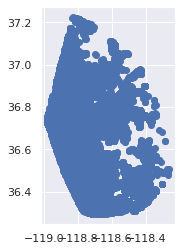

In [18]:
filter_within_geometry(gedi_trees_gdf, seki).plot()

In [7]:
terrain_gedi_matched = terrain_raster.sample_2x2(gedi_trees, 'lon_lowestmode', 'lat_lowestmode')

In [8]:
terrain_gedi_matched

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,...,slope_std,slope_median,aspect_2x2,aspect_mean,aspect_std,aspect_median,soil_2x2,soil_mean,soil_std,soil_median
30377,141320600300524403,2021-06-11 01:03:13.232091+00:00,-121.065232,38.523326,29.816301,6.703417,69.418312,2.982733,full,0.966228,...,0.000000,16.0,"[218, 218, 218, 218]",218.00,0.000000,218.0,"[67, 67, 67, 67]",67.0,0.0,67.0
30378,141320600300524405,2021-06-11 01:03:13.248619+00:00,-121.064224,38.522668,28.796034,6.224873,67.855049,2.982503,full,0.965935,...,3.937004,9.5,"[191, 172, 27, 178]",142.00,66.749532,175.0,"[67, 67, 67, 67]",67.0,0.0,67.0
30379,141320600300524406,2021-06-11 01:03:13.256883+00:00,-121.063721,38.522340,48.694904,16.833782,97.090446,2.990923,full,0.963867,...,0.500000,9.5,"[178, 27, 178, 27]",102.50,75.500000,102.5,"[67, 67, 67, 67]",67.0,0.0,67.0
30381,141320600300524408,2021-06-11 01:03:13.273411+00:00,-121.062714,38.521683,21.426817,3.090621,56.247093,2.981820,full,0.962257,...,3.000000,9.0,"[42, 143, 42, 143]",92.50,50.500000,92.5,"[67, 67, 67, 67]",67.0,0.0,67.0
30479,169790800200082537,2021-12-11 17:35:08.887395+00:00,-121.066418,38.526989,16.838388,1.518356,48.646515,2.982546,full,0.957908,...,2.500000,9.5,"[247, 247, 228, 228]",237.50,9.500000,237.5,"[67, 67, 67, 67]",67.0,0.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27623252,192410600300534401,2022-05-06 14:47:14.435166+00:00,-119.970015,36.863622,21.251682,3.024314,55.963173,2.981828,full,0.968922,...,0.000000,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0
27623277,42030600300533058,2019-09-09 14:31:54.505967+00:00,-119.971450,36.864930,18.489573,2.041736,51.423347,2.982156,full,0.971968,...,0.000000,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0
27623278,42030600300533061,2019-09-09 14:31:54.530760+00:00,-119.970006,36.863913,20.158594,2.620811,54.180977,2.981914,full,0.975002,...,0.000000,0.0,"[0, 0, 0, 0]",0.00,0.000000,0.0,"[0, 0, 0, 0]",0.0,0.0,0.0
27626190,187680500300286974,2022-04-06 02:51:43.105139+00:00,-119.885997,36.855828,43.790302,14.013438,90.086578,2.988213,full,0.957947,...,0.500000,4.5,"[104, 108, 104, 108]",106.00,2.000000,106.0,"[255, 255, 255, 255]",255.0,0.0,255.0


In [9]:
terrain_gedi_matched.to_csv(f'/maps/fire-regen/data/sierras_matched_terrain_2x2.csv')

KeyboardInterrupt: 

### Match GEDI data with rasters, to create training data for Random Forests

#### Get GEDI data

In [3]:
gedi_shots = pd.read_csv('/maps/fire-regen/data/sierras_gedi_shots.csv', index_col=0)

In [9]:
processed_gedi_shots = gedi_pipeline.initial_l4a_shot_processing(gedi_shots)

In [13]:
processed_gedi_shots.to_csv('/maps/fire-regen/data/rf/sierras_gedi_shots.csv')

In [6]:
gedi_shots = pd.read_csv('/maps/fire-regen/data/rf/sierras_gedi_shots.csv')

#### Get Rasters

In [7]:
burn_raster = raster.RasterSampler(raster.BURN_DATA_RASTER, raster.BURN_RASTER_BANDS)

In [8]:
landsat_2018 = raster.RasterSampler(raster.LANDSAT_RASTER(2018), raster.LANDSAT_BANDS)
landsat_2019 = raster.RasterSampler(raster.LANDSAT_RASTER(2019), raster.LANDSAT_BANDS)
landsat_2020 = raster.RasterSampler(raster.LANDSAT_RASTER(2020), raster.LANDSAT_BANDS)
landsat_2021 = raster.RasterSampler(raster.LANDSAT_RASTER(2021), raster.LANDSAT_BANDS)

In [9]:
dynamic_world_2018 = raster.RasterSampler(raster.DYNAMIC_WORLD_RASTER(2018), raster.LAND_COVER_BANDS)
dynamic_world_2019 = raster.RasterSampler(raster.DYNAMIC_WORLD_RASTER(2019), raster.LAND_COVER_BANDS)
dynamic_world_2020 = raster.RasterSampler(raster.DYNAMIC_WORLD_RASTER(2020), raster.LAND_COVER_BANDS)
dynamic_world_2021 = raster.RasterSampler(raster.DYNAMIC_WORLD_RASTER(2021), raster.LAND_COVER_BANDS)

In [10]:
terrain_raster = raster.RasterSampler(raster.TERRAIN_RASTER, raster.TERRAIN_BANDS)

#### Match Burn raster

With burn raster, we actually match with 2x2 pixels, since we might want higher precision for various reasons.

In [8]:
gedi_matched = burn_raster.sample_2x2(gedi_shots, 'longitude', 'latitude')

KeyboardInterrupt: 

Let's see how many pixels we have that burned in 2019-2022. We might want to get rid of those, since it's easier if we don't have to keep track of GEDI shots before and after fires for each fire in that period. Those recent fires are also less relevant for the study of regrowth, as they have happened too recently.

We can analyze them separately, to answer different questions.

In [21]:
gedi_matched.to_csv('/maps/fire-regen/data/rf/2_gedi_shots_matched_burn.csv')

In [11]:
gedi_matched = pd.read_csv('/maps/fire-regen/data/rf/2_gedi_shots_matched_burn.csv', index_col=0)

In [12]:
# Exclude shots on the burn boundaries.
gedi_matched = gedi_matched[(gedi_matched.burn_counts_std == 0) & (gedi_matched.burn_year_std == 0)]
gedi_matched.shape[0]

9446235

In [13]:
recent_burns = gedi_matched[gedi_matched.burn_year_mean >= 2019]
gedi_matched_rest = gedi_matched[gedi_matched.burn_year_mean < 2019]
gedi_matched_rest.shape[0]

9032765

### Match terrain

In [14]:
gedi_matched_terrain = terrain_raster.sample_2x2(gedi_matched_rest, 'longitude', 'latitude')

#### Separate GEDI shots per year

We separate GEDI shots according to the year GEDI was shot. For each year, we take rasters from the year before, and use them as features.

In [15]:
gedi_2019 = gedi_matched_terrain[gedi_matched_terrain.gedi_year == 2019]
gedi_2020 = gedi_matched_terrain[gedi_matched_terrain.gedi_year == 2020]
gedi_2021 = gedi_matched_terrain[gedi_matched_terrain.gedi_year == 2021]
gedi_2022 = gedi_matched_terrain[gedi_matched_terrain.gedi_year == 2022]
print(gedi_2019.shape[0] + gedi_2020.shape[0] + gedi_2021.shape[0] + gedi_2022.shape[0])
print(gedi_matched_terrain.shape[0])

9032765
9032765


### Match Dynamic World

In [16]:
print('Match 2019')
gedi_2019_dw_match = dynamic_world_2018.sample_2x2(gedi_2019, 'longitude', 'latitude')
print('Match 2020')
gedi_2020_dw_match = dynamic_world_2019.sample_2x2(gedi_2020, 'longitude', 'latitude')
print('Match 2021')
gedi_2021_dw_match = dynamic_world_2020.sample_2x2(gedi_2021, 'longitude', 'latitude')
print('Match 2022')
gedi_2022_dw_match = dynamic_world_2021.sample_2x2(gedi_2022, 'longitude', 'latitude')

Match 2019
Match 2020
Match 2021
Match 2022


In [17]:
print('Match 2019')
gedi_2019_ls_match = landsat_2018.sample_2x2(gedi_2019_dw_match, 'longitude', 'latitude')
print('Match 2020')
gedi_2020_ls_match = landsat_2019.sample_2x2(gedi_2020_dw_match, 'longitude', 'latitude')
print('Match 2021')
gedi_2021_ls_match = landsat_2020.sample_2x2(gedi_2021_dw_match, 'longitude', 'latitude')
print('Match 2022')
gedi_2022_ls_match = landsat_2021.sample_2x2(gedi_2022_dw_match, 'longitude', 'latitude')

Match 2019
Match 2020
Match 2021
Match 2022


In [18]:
print('Save 2019')
gedi_2019_ls_match.to_csv(f"/maps/fire-regen/data/rf/gedi_2019_jun_2.csv")
print('Save 2020')
gedi_2020_ls_match.to_csv(f"/maps/fire-regen/data/rf/gedi_2020_jun_2.csv")
print('Save 2021')
gedi_2021_ls_match.to_csv(f"/maps/fire-regen/data/rf/gedi_2021_jun_2.csv")
print('Save 2022')
gedi_2022_ls_match.to_csv(f"/maps/fire-regen/data/rf/gedi_2022_jun_2.csv")

Save 2019
Save 2020
Save 2021
Save 2022
